In [71]:
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict
import re
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [72]:

# Function Definitions
def queryit(cursor, query): 
    cursor.execute(query)
    return cursor.fetchall()

def calculate_frequency(models_per_task):
    frequency_data = {}
    for task, timestamps in models_per_task.items():
        frequency = {}
        for timestamp in timestamps:
            year_month = timestamp[:7]  # Extract Year-Month
            frequency[year_month] = frequency.get(year_month, 0) + 1
        frequency_data[task] = frequency
    return frequency_data

def parse_single_file(url):
    response = requests.get(url)
    return response.content.decode("utf-8")

def extract_params(returned): 
    match = re.search(r'">(.*?) params<', returned)
    return match.group(1) if match else None

def replace_tag(row_dict, tag_to_domain): 
    for repo_url in row_dict:
        row_dict[repo_url]['domain.name'] = None
        for domain in tag_to_domain: 
            if row_dict[repo_url]['tag.name'] in tag_to_domain[domain]: 
                row_dict[repo_url]['domain.name'] = domain

def mil_bil(x):
    try:  
        if 'M' in x: 
            return 1000000 * float(re.sub('(M)', '', x))
        elif 'B' in x: 
            return 1000000000 * float(re.sub('(B)', '', x))
        else: 
            return 0
    except ValueError: 
        return 0 

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

In [73]:
conn = sqlite3.connect('./PeaTMOSS.db')
cursor = conn.cursor()

In [189]:
hub_id = 2
query = '''
    SELECT 
        reuse_repository.id, 
        GROUP_CONCAT(tag.name) AS tags
    FROM 
        model
    INNER JOIN model_to_tag ON model.id = model_to_tag.model_id
    INNER JOIN tag ON model_to_tag.tag_id = tag.id
    INNER JOIN model_to_reuse_repository ON model.id = model_to_reuse_repository.model_id
    INNER JOIN reuse_repository ON reuse_repository.id = model_to_reuse_repository.reuse_repository_id
    WHERE 
        model.model_hub_id = 2
    GROUP BY reuse_repository.id
'''
rows_hub = queryit(cursor, query)

In [190]:
rows_hub

[(2,
  'cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers'),
 (3,
  'vision,video,vision,video,vision,video,cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers'),
 (6, 'cuda-optional,vision,scriptable,researchers'),
 (8, 'cuda-optional,vision,scriptable,researchers'),
 (10, 'cuda-optional,vision,scriptable,researchers'),
 (12, 'cuda-optional,vision,scriptable,researchers'),
 (15, 'cuda-optional,vision,scriptable,researchers'),
 (16, 'cuda-optional,vision,scriptable,researchers'),
 (18,
  'cuda-optional,vision,scriptable,researchers,cuda-optional,vision,scriptable,researchers'),
 (19, 'cuda-optional,vision,scriptable,researchers'),
 (22, 'cuda-optional,vision,scriptable,researchers'),
 (23, 'cuda-optional,vision,scriptable,researchers'),
 (24, 'cuda-optional,vision,scriptable,research

In [191]:
domains = {
        'NLP': ['nlp'],
        'Computer Vision': ['generative', 'video', 'object_detection', 'segmentation', 'vision', 'optical_flow'],
        'Audio': ['audio'],
        'Multimodal': [],
        'Other': ['researchers', 'cuda-optional', 'cuda', 'quantization', 'scriptable']
    }

In [192]:
data = [(row[0], row[1]) for row in rows_hub]
len(data)

7253

In [193]:
store = {} 
for da in data: 
  if da[0] not in store: 
      store[da[0]] = []

  for domain_name, tasks in domains.items():
    for task in tasks:
      if task in da[1]:
        if domain_name not in store[da[0]]:
          store[da[0]].append(domain_name)

In [194]:
# Iterate through the dictionary and update tags
for key, tag_list in store.items():
    # Filter out "Other" from the tag list
    filtered_tag_list = [tag for tag in tag_list if tag != "Other"]

    if len(filtered_tag_list) == 0:
        # If the list is empty after removing "Other", label it as "Other"
        store[key] = ["Other"]
    elif len(filtered_tag_list) >= 2:
        # If there are two or more tags after filtering, label it as "Multimodal"
        store[key] = ["Multimodal"]
    else:
        # If there is one tag after filtering, keep it as it is
        store[key] = filtered_tag_list

In [195]:
tags = list(store.values())
tags

[['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Compute

In [196]:
final_pytorch = {x: 0 for x in domains}
for tag in tags: 
  for domain in tag: 
    final_pytorch[domain] += 1

In [197]:
hub_id = 1
query = '''
    SELECT 
        reuse_repository.id,
        GROUP_CONCAT(tag.name) AS tags
    FROM 
        model
    LEFT JOIN model_to_tag ON model.id = model_to_tag.model_id
    LEFT JOIN tag ON model_to_tag.tag_id = tag.id
    INNER JOIN model_to_reuse_repository ON model.id = model_to_reuse_repository.model_id
    INNER JOIN reuse_repository ON reuse_repository.id = model_to_reuse_repository.reuse_repository_id
    WHERE 
        model.model_hub_id = 1
    GROUP BY reuse_repository.id
    HAVING tags IS NOT NULL
'''
rows_hub = queryit(cursor, query)

In [198]:
len(rows_hub)

8593

In [199]:
rows_hub

[(481, 'autotrain_compatible,has_space,albert,question-answering'),
 (486,
  'autotrain_compatible,text2text-generation,summarization,model-index,has_space,bart'),
 (542, 'text-generation-inference,gpt2,text-generation,has_space,exbert'),
 (596, 'text-classification,distilbert,model-index,has_space'),
 (1348,
  'autotrain_compatible,text2text-generation,has_space,mbart,mbart-50,autotrain_compatible,text2text-generation,has_space,translation,marian'),
 (1964, 'autotrain_compatible,has_space,bert,fill-mask,exbert'),
 (1965, 'autotrain_compatible,has_space,bert,fill-mask,exbert'),
 (2221, 'model-index,has_space,token-classification'),
 (2444, 'text-generation-inference,gpt2,text-generation,has_space,exbert'),
 (2452,
  'text-classification,bert,feature-extraction,text-classification,has_space,bert,sentiment-analysis'),
 (2514, 'electra,pretraining'),
 (2670, 'autotrain_compatible,has_space,bert,fill-mask,exbert'),
 (2766, 'text-classification,distilbert,model-index,has_space'),
 (2774,
  

In [200]:
domains  = {
    'Multimodal': ['feature-extraction', 'text-to-image', 'image-to-text', 'text-to-video', 'visual-question-answering', 'graph-machine-learning'],
    'Computer Vision': ['depth-estimation', 'image-classification', 'object-detection', 'image-segmentation', 'image-to-image', 'unconditional-image-generation', 'video-classification', 'zero-shot-image-classification'],
    'NLP': ['text-classification', 'token-classification', 'table-question-answering', 'question-answering', 'zero-shot-classification', 'translation', 'summarization', 'conversational', 'text-generation', 'text2text-generation', 'fill-mask', 'sentence-similarity', 'table-to-text', 'multiple-choice', 'text-retrieval'],
    'Audio': ['text-to-speech', 'text-to-audio', 'automatic-speech-recognition', 'audio-to-audio', 'audio-classification', 'voice-activity-detection'],
    'Other': ['reinforcement-learning','robotics','tabular-classification','tabular-regression','tabular-to-text','time-series-forecasting']
}

In [201]:
data = [(row[0], row[1]) for row in rows_hub]
len(data)

8593

In [202]:
len(data)

8593

In [203]:

store = {} 
for da in data: 
  if da[0] not in store: 
      store[da[0]] = []

  for domain_name, tasks in domains.items():
    for task in tasks:
      if task in da[1]:
        if domain_name not in store[da[0]]:
          store[da[0]].append(domain_name)

In [204]:
len(store)

8593

In [205]:
# Iterate through the dictionary and update tags
for key, tag_list in store.items():
    if len(tag_list) >= 2:
        store[key] = ["Multimodal"]


In [206]:
store

{481: ['NLP'],
 486: ['NLP'],
 542: ['NLP'],
 596: ['NLP'],
 1348: ['NLP'],
 1964: ['NLP'],
 1965: ['NLP'],
 2221: ['NLP'],
 2444: ['NLP'],
 2452: ['Multimodal'],
 2514: [],
 2670: ['NLP'],
 2766: ['NLP'],
 2774: ['Audio'],
 2879: ['NLP'],
 2983: ['NLP'],
 3056: ['NLP'],
 3147: ['NLP'],
 3186: ['Multimodal'],
 3217: ['NLP'],
 3226: ['NLP'],
 3266: ['NLP'],
 3312: ['NLP'],
 3324: ['NLP'],
 3435: ['Computer Vision'],
 3668: ['NLP'],
 3999: ['NLP'],
 4052: ['NLP'],
 4185: ['NLP'],
 4590: ['NLP'],
 4591: ['NLP'],
 4596: ['NLP'],
 4597: ['NLP'],
 4600: ['NLP'],
 4609: ['NLP'],
 4617: ['NLP'],
 4631: ['NLP'],
 4641: ['NLP'],
 4642: ['NLP'],
 4643: ['NLP'],
 4647: ['NLP'],
 4651: ['NLP'],
 4654: ['NLP'],
 4655: ['NLP'],
 4658: ['NLP'],
 4663: ['NLP'],
 4664: ['NLP'],
 4680: ['Multimodal'],
 4682: ['NLP'],
 4684: ['NLP'],
 4687: ['NLP'],
 4689: ['NLP'],
 4700: ['NLP'],
 4701: ['NLP'],
 4703: ['NLP'],
 4704: ['Computer Vision'],
 4706: ['NLP'],
 4707: ['NLP'],
 4709: ['NLP'],
 4715: ['NLP'],
 4

In [207]:
tags = list(store.values())
tags, len(tags)

([['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Multimodal'],
  [],
  ['NLP'],
  ['NLP'],
  ['Audio'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Multimodal'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Computer Vision'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Multimodal'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Computer Vision'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['Multimodal'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['NLP'],
  ['N

In [208]:
final_hf = {x: 0 for x in domains}
for tag in tags: 
  for domain in tag: 
    final_hf[domain] += 1

In [209]:
final_hf

{'Multimodal': 1457,
 'Computer Vision': 529,
 'NLP': 6318,
 'Audio': 80,
 'Other': 0}

In [210]:
final_pytorch

{'NLP': 162,
 'Computer Vision': 6964,
 'Audio': 85,
 'Multimodal': 42,
 'Other': 0}

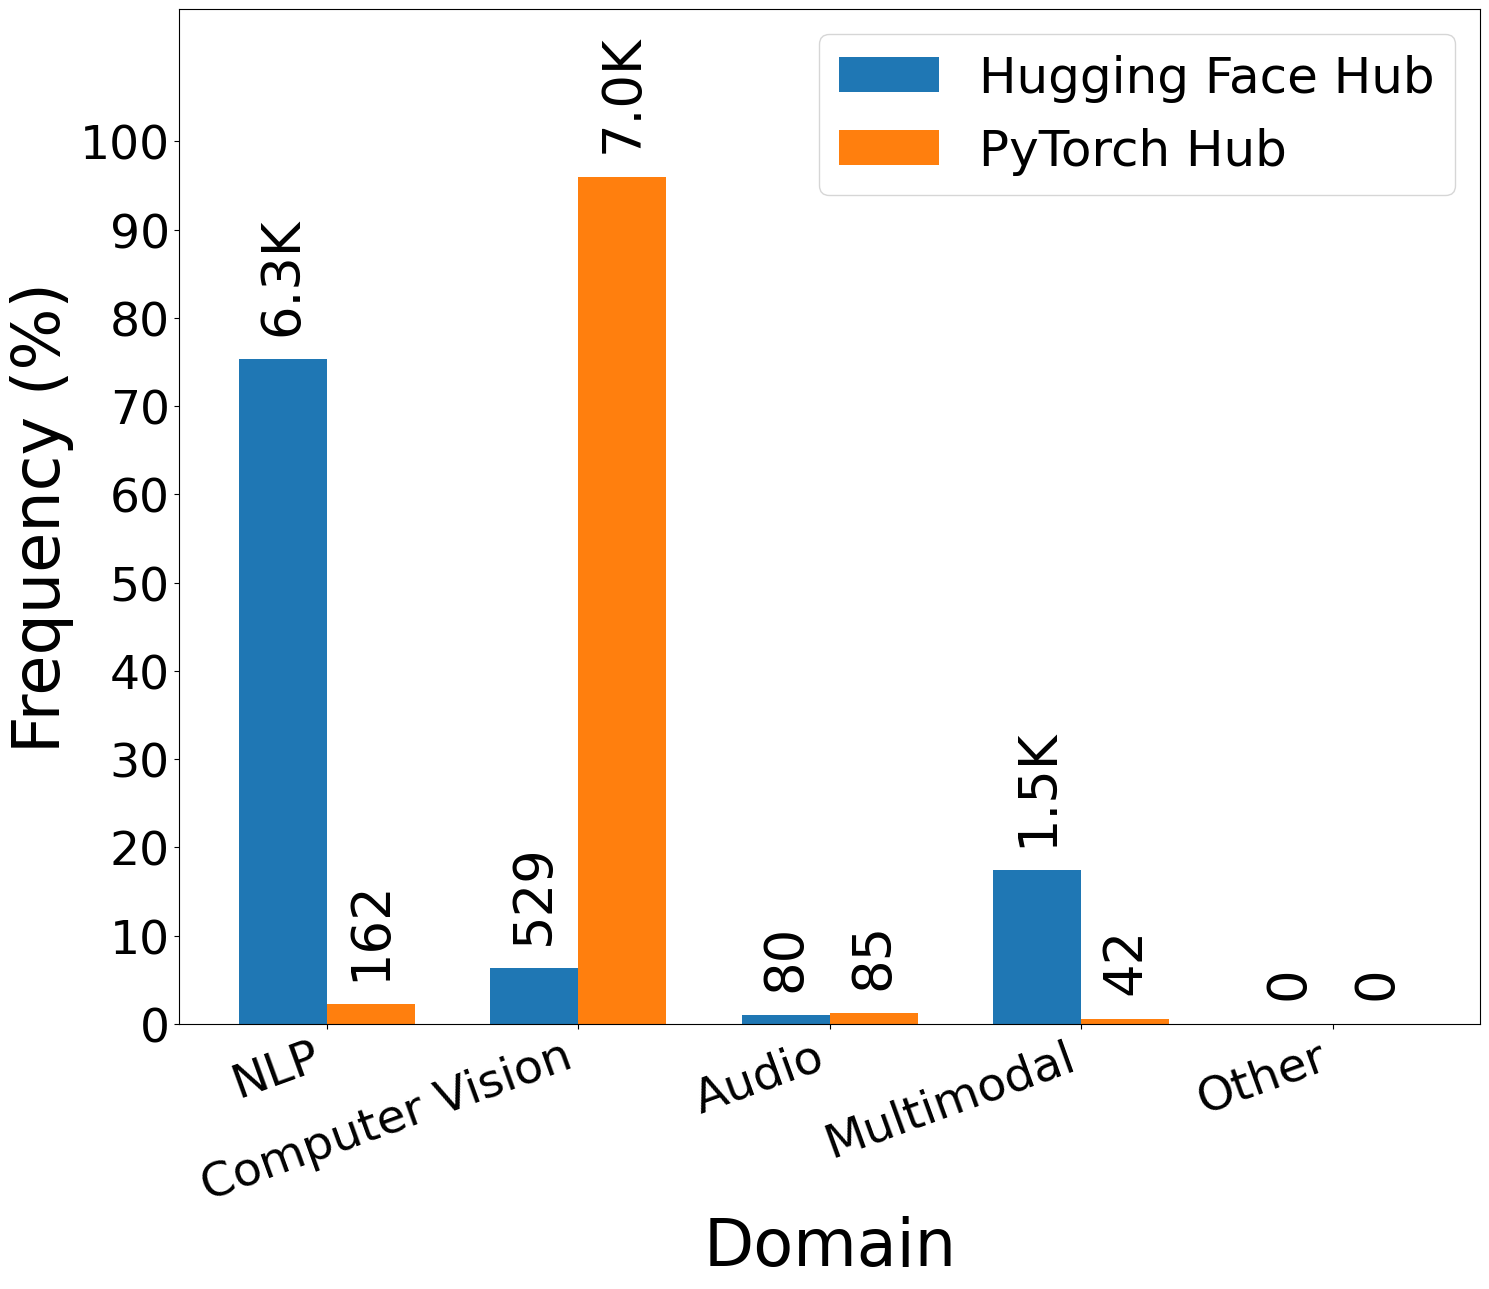

In [221]:
total_hf = sum(final_hf.values())
total_pytorch = sum(final_pytorch.values())


total1 = total_hf
total2 = total_pytorch

# Calculate the domain counts for both hubs
domain_counts_hub1 = {key: 100 * (value / total1) for key, value in final_hf.items()}
domain_counts_hub2 = {key: 100 * (value / total2) for key, value in final_pytorch.items()}

# Set the order of the domains
tags = ['NLP', 'Computer Vision', 'Audio', 'Multimodal', 'Other']

# Get frequencies for both hubs according to the specified order
freq_hub1 = [domain_counts_hub1.get(tag, 0) for tag in tags]
freq_hub2 = [domain_counts_hub2.get(tag, 0) for tag in tags]

# Bar plot settings
bar_width = 0.35
index = np.arange(len(tags))

plt.figure(figsize=(15, 13))

plt.bar(index, freq_hub1, bar_width, alpha=1, label='Hugging Face Hub')
plt.bar(index + bar_width, freq_hub2, bar_width, alpha=1, label='PyTorch Hub')
for i in index: 
    text1 = total1 * (freq_hub1[i] / 100)
    text2 = total2 * (freq_hub2[i] / 100)

    # If text1 is in the thousands, I want to append a K to the end of it 
    if text1 > 1000: 
        text1 = str(round((text1 / 1000), 1)) + 'K'
    else: 
        text1 = str(round(text1)) 
    if text2 > 1000:
        text2 = str(round((text2 / 1000), 1)) + 'K'
    else:
        text2 = str(round(text2)) 


    plt.text(i, freq_hub1[i] + 4, text1 , ha = 'center', fontsize = 38, rotation=90)
    plt.text(i + bar_width, freq_hub2[i] + 4, text2, ha = 'center', fontsize = 38, rotation=90)

plt.xlabel('Domain', fontsize=47)
plt.ylabel('Frequency (%)', fontsize=47)
plt.xticks(index + bar_width / 2, tags, rotation=20, fontsize=28, ha='right')
plt.yticks(fontsize=34)
plt.xticks(fontsize=34)

# plt.yscale('log')
plt.legend(fontsize=36)
plt.ylim(0, 115)
plt.yticks(np.arange(0, 101, step=10))  # Adjust step as needed for your scale
plt.tight_layout()
plt.savefig('./fig9.pdf')
plt.show()

In [213]:
perc_hf = {}
# calcualte percentage of each values
for key, item in final_hf.items():
    perc_hf[key] = f"{item/total_hf * 100:.2f}%"
perc_hf

{'Multimodal': '17.38%',
 'Computer Vision': '6.31%',
 'NLP': '75.36%',
 'Audio': '0.95%',
 'Other': '0.00%'}

In [214]:
perc_pytorch = {}
# calcualte percentage of each values
for key, item in final_pytorch.items():
    perc_pytorch[key] = f"{item/total_pytorch * 100:.2f}%"
perc_pytorch

{'NLP': '2.23%',
 'Computer Vision': '96.02%',
 'Audio': '1.17%',
 'Multimodal': '0.58%',
 'Other': '0.00%'}